Read in our training data

In [ ]:
import numpy as np

train_csv = np.loadtxt("train.csv", dtype={'names': ('movie-id','customer-id','rating','date'), 
                                   'formats':('i4','i4','i4','a10')},
               delimiter=',',
               skiprows=1
              )


Get some summary stats on our users. Create user_list, a list of all unique customer-id values. Then create user_dict, which will take customer-id as a key and return position within user_list (henceforth referred to as 'user_id') as value.

Then do the exact same thing for movies.

In [ ]:
import random

#users
user_set = set([each[1] for each in train_csv])
f_user_list  = list(user_set) #full user list
del user_set

user_dict = {}
for i, user_id in  enumerate(f_user_list):
    user_dict[user_id] = i

    
#movies
movie_set = set([each[0] for each in train_csv])
movie_list  = list(movie_set)
del movie_set

movie_dict = {}
for i, movie_id in  enumerate(movie_list):
    movie_dict[movie_id] = i


Now let's create a matrix, Data_M, with a row for each user and column for each movie. Then we'll iterate through the training data and fill it in.

In [ ]:
Data_M = np.zeros( (len(f_user_list),len(movie_list)), dtype='i4')

for each in  train_csv:
    user = each[1]
    movie = each[0]
    rating = each[2]
    Data_M[user_dict[user],movie_dict[movie]] = rating

Pickle and dump it to save our work

In [ ]:
import pickle

with open('Data_M.pickle', 'wb') as handle:
  pickle.dump(Data_M, handle, protocol=2)

In [ ]:
#grab a subset of Data_M, so our trial analyses take less time to run
import random


s_u_size = 1000
s_user_list = []
temp_user_list  = list(f_user_list)

for each in range(0,s_u_size):
    i = random.randrange(0,len(temp_user_list))
    user = temp_user_list.pop(i)
    s_user_list.append(user)

del temp_user_list


#s_Data_M = np.zeros( (len(s_user_list),len(movie_list)), dtype='i4')

#for i,user_id in  enumerate(s_user_list):
#    s_Data_M[i] = Data_M[user_dict[user_id]]
        



Define a similarity metric. It is currently 5 minus the absolute difference between the two user ratings, summed over all movies rated by each user, and divided by the squareroot of the number of movies each rated.



In [ ]:
import  math
def calc_similarity(i,j):
    m_count = 0 #a count of movies rated by both users
    r_count = 0 # rating similarity count   

    mutually_rated_movies = np.logical_and(Data_M[i],Data_M[j])
    x = np.where(mutually_rated_movies == True)
    
    #if no movies were mutually rated
    if x[0].size is 0:
        return 0
    
    else:
        for z in np.nditer(x):
            r_count += 5 - abs(Data_M[i, z] - Data_M[j, z])
            m_count += 1

        return r_count / math.sqrt(m_count)

In [ ]:
import scipy
from scipy.spatial import distance


def calc_cos_similarity(i,j):
    m_count = 0 #a count of movies rated by both users
    r_count = 0 # rating similarity count   

    #mutually_rated_movies = np.logical_and(Data_M[i],Data_M[j])
    #x = np.where(mutually_rated_movies == True)
    
    #if no movies were mutually rated
    #if x[0].size is 0:
    #    return 0
    
    #else:
    return scipy.spatial.distance.cosine(Data_M[i], Data_M[j])

In [ ]:
#use variables with s_ prefix when using a subset of the code  
user_list = f_user_list
#user_list = s_user_list

dim = len(user_list)


#initialize our matrix to all zeros
W = np.zeros( (len(user_list),len(user_list) )) 

#calculate similarity matrix
for i in range(0,len(user_list)-1):
    if i % 10 == 0:
        print "On user"+str(i)
    for j in range(i+1,len(user_list)):

        similarity  = calc_cos_similarity(user_dict[user_list[i]],user_dict[user_list[j]])
        
        W[i,j] = W[j,i] = similarity

    

    


Pickle so we don't need to go through that eternity again 

In [ ]:
#import pickle

#with open('W.pickle', 'wb') as handle:
#  pickle.dump(W, handle, protocol=2)


Pick up where we left off

In [22]:
import pickle

with open('W.pickle', 'rb') as handle:
    W = pickle.load(handle)
    #, encoding='latin1') #annie had to do latin1 thing to fix python version incompatibility :(

#print "Loaded array of size "+str(dim)+" x "+str(dim)

Now we make our graph a bit more sparse, by snipping edges with a weight less than epsilon. This will need to be switched over to a knn algorithm to avoid having our Laplacian lose rank

In [23]:
import heapq
import pprint as pp
import numpy
import csv
def get_prune_matrix(matrix, k):
    asym = numpy.zeros((len(matrix), len(matrix))) #asymmetric matrix storing first pass of KNN tests
    pruned_matrix = numpy.zeros((len(matrix), len(matrix))) #symmetric pruned version of original matrix (mutual KNN)
    
    #for each row, sort values and find k "most similar" users; set others to 0
    for i in range(len(matrix)):
        row = matrix[i]
        indices = heapq.nlargest(k, range(len(row)), row.__getitem__)
        for ind in indices:
            asym[i, ind] = 1
            
    #create the symmetric mutual KNN matrix:
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if asym[i,j] == 1 or asym[j,i] == 1:
                pruned_matrix[i,j] = matrix[i,j]
                
    return pruned_matrix
            
    asym_file = open("asym.csv", "w")
    wr = csv.writer(asym_file, quoting=csv.QUOTE_ALL)
    w_list = numpy.ndarray.tolist(pruned_matrix)
    wr.writerows(w_list)

nn = 25
pruned_W = get_prune_matrix(W, nn)

In [24]:
del W

In [ ]:
# check if pruned_W is symmetric
#for i in range(len(pruned_W)):
#    for j in range(len(pruned_W)):
#        if pruned_W[i, j] != pruned_W[j, i]:
#            print("false!")

In [ ]:
#Here is where we should sparse up our matrix, using either an epsilon cutoff or k nearest neighbor approach
#def epsilon_neighbor_prune(i,j):
#    epsilon = 10
#    if W[i,j] < epsilon:
#        W[i,j] = W[j,i] = 0
        
#prune!
#print "starting"
#for i in range(0,dim-1):
#    if i % 100 == 0:
#        print "Pruning user"+str(i)
#    for j in range(i+1,dim):
#        epsilon_neighbor_prune(i,j)
    

Now construct our Laplacian

In [47]:
import numpy as  np
from numpy.linalg import  inv
dim =  len(pruned_W)

D = np.zeros((dim,dim)) 

for i in range(0,dim):
    D[i,i] = sum(pruned_W[i])

L = D - pruned_W


let's find some eigenstuff! this matrix is super sparse, so we can use scipy.sparse.

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

vals, vecs = numpy.linalg.eig(L)

In [49]:
del L
#print np.sort(vals)[0]
#plt.plot(vals[0:20])

In [ ]:
numpy.set_printoptions(threshold=numpy.nan)
print vals

Do k-means clustering on the rows of V...

<function matplotlib.pyplot.show>

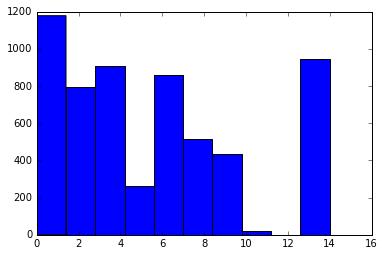

In [55]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

k = 15
km = KMeans(n_clusters=k)
indices = np.argsort(vals)[:k]
sortedVecs = vecs[:,indices]
km.fit(sortedVecs)
plt.hist(km.labels_)
plt.show
